Exploring a dataset with information about patients. 
Consider next 8 features to predict the mortality rate:
1. Age
2. CHF KiLLip
3. HBR (b)
4. Systolic AP(b)
5. Creatine in blood
6. EF Percentage
7. White blood cells count
8. Glucose

# 1. Import required libraries and load the dataset

In [85]:
import numpy as np
import pandas as pd
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras_tuner import RandomSearch, Objective
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

In [86]:
# Load dataset
ready_data = pd.read_csv('./import/dataset_prepared.csv')

# 2. Split the dataset into features and target.

In [87]:
X = ready_data.drop('Class', axis=1)
y = ready_data['Class']

We want to consider hyper parameters, so we will use three different random_state parameters. 

In [88]:
random_states = [0, 25, 42]

## 3. Keras

In [89]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [92]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=6, max_value=64, step=4), 
                    activation='relu', 
                    input_dim=8))
    model.add(Dense(units=hp.Int('units', min_value=6, max_value=64, step=4), 
                    activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    METRICS = [

      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

    model.compile(optimizer=tf.keras.optimizers.Adam(
                      learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', 
                  metrics=METRICS)
    return model

In [95]:
tuner = RandomSearch(
    build_model,
    objective=Objective('prc', direction='max'),
    max_trials=5,
    executions_per_trial=3,
    directory='export',
    project_name='keras_classification',
)

In [96]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 6, 'max_value': 64, 'step': 4, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [71]:
tuner_adam.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 6, 'max_value': 64, 'step': 4, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [72]:
tuner.search(X, y, epochs=5, validation_split=0.2, batch_size=10)

Trial 5 Complete [00h 00m 32s]
prc: 0.14874685307343802

Best prc So Far: 0.3231433828671773
Total elapsed time: 00h 02m 46s
INFO:tensorflow:Oracle triggered exit


In [73]:
tuner_adam.search(X, y, epochs=5, validation_split=0.2, batch_size=10)

Trial 5 Complete [00h 00m 34s]
prc: 0.07421479001641273

Best prc So Far: 0.3250868519147237
Total elapsed time: 00h 02m 53s
INFO:tensorflow:Oracle triggered exit


In [74]:
# Best params
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. \nThe optimal number of units in the first densely-connected layer is {best_hps.get('units')},
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')},
the best momentum is {best_hps.get('momentum')}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layer is 46,
the optimal learning rate for the optimizer is 0.01,
the best momentum is 0.9.



In [75]:
# Best params
best_hps_adam = tuner_adam.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. \nThe optimal number of units in the first densely-connected layer is {best_hps_adam.get('units')},
the optimal learning rate for the optimizer is {best_hps_adam.get('learning_rate')}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layer is 26,
the optimal learning rate for the optimizer is 0.01.



In [76]:
best_model_sgd = tuner.get_best_models(num_models=1)[0]
best_model_adam = tuner_adam.get_best_models(num_models=1)[0]

In [83]:
from sklearn.utils import class_weight

precision_list = []
recall_list = []
f1_list = []
f1_macro_list = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = tuner_adam.hypermodel.build(best_hps)
    # model_adam = tuner_adam.hypermodel.build(best_hps_adam)
    
    class_weights = class_weight.compute_sample_weight('balanced', y_train)


    model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=10, sample_weight=class_weights)
    # model_adam.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=10, sample_weight=class_weights)
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    
    # Получаем отчет классификации
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Добавляем метрики в списки
    precision_list.append(report['1']['precision'])
    recall_list.append(report['1']['recall'])
    f1_list.append(report['1']['f1-score'])
    f1_macro_list.append(f1_score(y_test, y_pred, average='macro'))

# Вычисляем средние значения
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_f1_macro = np.mean(f1_macro_list)

print('Average precision: ', avg_precision)
print('Average recall: ', avg_recall)
print('Average F1-score: ', avg_f1)
print('Average Macro F1-score: ', avg_f1_macro)
   

Epoch 1/5
242/242 [==============================] - 5s 9ms/step - loss: 0.5046 - tp: 67.0000 - fp: 438.0000 - tn: 1898.0000 - fn: 16.0000 - accuracy: 0.8123 - precision: 0.1327 - recall: 0.8072 - auc: 0.8602 - prc: 0.2438 - val_loss: 0.3357 - val_tp: 12.0000 - val_fp: 79.0000 - val_tn: 505.0000 - val_fn: 9.0000 - val_accuracy: 0.8545 - val_precision: 0.1319 - val_recall: 0.5714 - val_auc: 0.8423 - val_prc: 0.2721
Epoch 2/5
242/242 [==============================] - 1s 5ms/step - loss: 0.4340 - tp: 66.0000 - fp: 390.0000 - tn: 1946.0000 - fn: 17.0000 - accuracy: 0.8317 - precision: 0.1447 - recall: 0.7952 - auc: 0.8902 - prc: 0.2720 - val_loss: 0.4097 - val_tp: 14.0000 - val_fp: 95.0000 - val_tn: 489.0000 - val_fn: 7.0000 - val_accuracy: 0.8314 - val_precision: 0.1284 - val_recall: 0.6667 - val_auc: 0.8620 - val_prc: 0.3032
Epoch 3/5
242/242 [==============================] - 1s 6ms/step - loss: 0.4213 - tp: 67.0000 - fp: 391.0000 - tn: 1945.0000 - fn: 16.0000 - accuracy: 0.8317 - prec

In [43]:
y_pred = best_model.predict(X_test).round()
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Macro: {f1_score(y_test, y_pred, average='macro')}")

19/19 [==============================] - 0s 4ms/step
AUC-ROC: 0.525
Precision: 1.0
Recall: 0.05
F1 Macro: 0.539615677779115


In [44]:
import shap

In [45]:
explainer = shap.DeepExplainer(best_model, X_train)
shap_values = explainer.shap_values(X_test)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


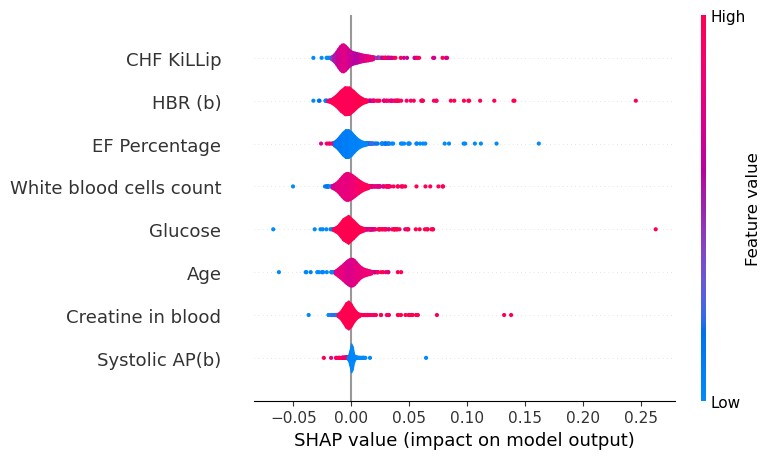

In [49]:
feature_names = ["Age", "CHF KiLLip", "HBR (b)", "Systolic AP(b)", "Creatine in blood", "EF Percentage", "White blood cells count", "Glucose"]
shap.summary_plot(shap_values[0], X_test, feature_names=feature_names, plot_type='violin')



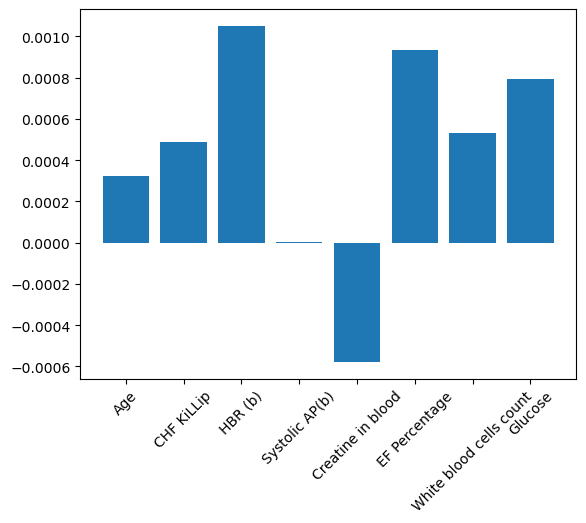

In [50]:
plt.bar(feature_names, np.mean(shap_values[0], axis=0))
plt.xticks(rotation=45)
plt.show()